In [1]:
import os
import platform
import sys
import shutil
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import torch
import torchvision

In [2]:
#电脑配置信息
print("Operating system: ", platform.platform(), platform.version())
print("Python version", sys.version)
print("Pandas version: ", pd.__version__)
print("Sklearn version: ", sklearn.__version__)
print("Pytorch version: ", torch.__version__)

Operating system:  Windows-10-10.0.22621-SP0 10.0.22621
Python version 3.8.10 (tags/v3.8.10:3d8993a, May  3 2021, 11:48:03) [MSC v.1928 64 bit (AMD64)]
Pandas version:  2.0.3
Sklearn version:  1.3.2
Pytorch version:  2.1.1+cpu


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print('Using device:', device)

Using device: cpu


In [4]:
RANDOM_STATE = 0
TRAIN_VS_VALIDATION_SET_PERCENTANGE = 0.8
BATCH_SIZE = 32
TRAIN_FULL_IMAGES_PATH = './imageclassification/temp/train'
TEST_FULL_IMAGES_PATH = './imageclassification/temp/test'
TRAIN_IMAGES_REORGANIZED_PATH = './imageclassification/temp/train_reorganized'
VALID_IMAGES_REORGANIZED_PATH = './imageclassification/temp/valid_reorganized'
TEST_IMAGES_REORGANIZED_PATH = './imageclassification/temp/test_reorganized'
TEST_IMAGES_REORGANIZED_PLACEHOLDER_LABEL_PATH = f"{TEST_IMAGES_REORGANIZED_PATH}/unknown"

In [5]:
train_full_labels = pd.read_csv('./imageclassification/temp/trainLabels.csv', index_col='id')

In [6]:
from sklearn.model_selection import train_test_split

train_labels, valid_labels = train_test_split(
    train_full_labels,
    train_size=TRAIN_VS_VALIDATION_SET_PERCENTANGE,
    shuffle=True,
    random_state=RANDOM_STATE
)

In [7]:
train_labels

,label
id,
20331,cat
17533,horse
45820,dog
34808,horse
31889,airplane
...,...
21244,airplane
45892,dog
42614,dog


In [8]:
#重新组织图像文件
def reorganize_images(labels, source_path, destination_path):
    for label in labels["label"].unique():
        class_path = os.path.join(destination_path, str(label))
        print(f"Creating class path: {class_path}")
        os.makedirs(class_path, exist_ok=True)
        
    for idx, row in labels.iterrows():
        id = row.name
        label = row["label"]
        source_image_path = os.path.join(source_path, f"{id}.png")
        destination_image_path = os.path.join(destination_path, str(label), f"{id}.png")

        # 如果目标图像文件已经存在，则删除
        if os.path.isfile(destination_image_path):
            os.remove(destination_image_path)

        # 复制文件到新目录
        shutil.copy(source_image_path, destination_image_path)

# 使用示例
reorganize_images(train_labels, TRAIN_FULL_IMAGES_PATH, TRAIN_IMAGES_REORGANIZED_PATH)
reorganize_images(valid_labels, TRAIN_FULL_IMAGES_PATH, VALID_IMAGES_REORGANIZED_PATH)

Creating class path: ./imageclassification/temp/train_reorganized\cat
Creating class path: ./imageclassification/temp/train_reorganized\horse
Creating class path: ./imageclassification/temp/train_reorganized\dog
Creating class path: ./imageclassification/temp/train_reorganized\airplane
Creating class path: ./imageclassification/temp/train_reorganized\ship
Creating class path: ./imageclassification/temp/train_reorganized\truck
Creating class path: ./imageclassification/temp/train_reorganized\bird
Creating class path: ./imageclassification/temp/train_reorganized\automobile
Creating class path: ./imageclassification/temp/train_reorganized\frog
Creating class path: ./imageclassification/temp/train_reorganized\deer
Creating class path: ./imageclassification/temp/valid_reorganized\horse
Creating class path: ./imageclassification/temp/valid_reorganized\dog
Creating class path: ./imageclassification/temp/valid_reorganized\frog
Creating class path: ./imageclassification/temp/valid_reorganized\d

In [9]:
from torchvision.transforms import Compose, ToTensor, Normalize

mean = torch.tensor([0.4914, 0.4822, 0.4465])
std = torch.tensor([0.2023, 0.1994, 0.2010])

transform = Compose([
    ToTensor(),
    Normalize(mean, std)
])

In [10]:
from torchvision.datasets import ImageFolder

train_images = ImageFolder(TRAIN_IMAGES_REORGANIZED_PATH, transform=transform)
valid_images = ImageFolder(VALID_IMAGES_REORGANIZED_PATH, transform=transform)

airplane
torch.Size([3, 32, 32])


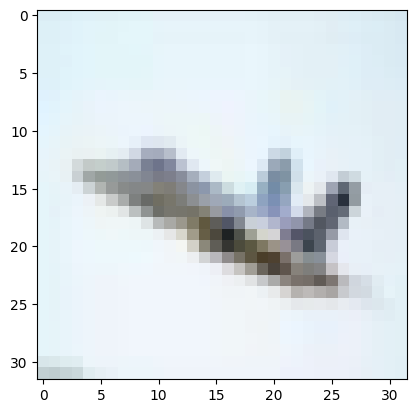

In [11]:
#图片展示
def display_img(img):

    PIL_RGB_image = img.permute(1, 2, 0)
    img = PIL_RGB_image * std + mean
    plt.imshow(img.numpy())

sample_image, sample_label_index = train_images[0]
display_img(sample_image)
print(train_images.classes[sample_label_index])
print(sample_image.shape)

In [12]:
#建立一个简单的模型
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 第一个卷积层：输入通道为3（RGB图像），输出通道为6，卷积核大小为5x5
        self.conv1 = nn.Conv2d(3, 6, 5)
        # 最大池化层：池化窗口大小为2x2，步幅为2
        self.pool = nn.MaxPool2d(2, 2)
        # 第二个卷积层：输入通道为6，输出通道为16，卷积核大小为5x5
        self.conv2 = nn.Conv2d(6, 16, 5)
        # 第一个全连接层：输入维度为16*5*5，输出维度为120
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # 第二个全连接层：输入维度为120，输出维度为84
        self.fc2 = nn.Linear(120, 84)
        # 输出层：输入维度为84，输出维度为10（对应分类的类别数）
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(swish(self.conv1(x)))
        x = self.pool(swish(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = swish(self.fc1(x))
        x = swish(self.fc2(x))
        x = self.fc3(x)
        return x
def swish(x):
    return x * torch.sigmoid(x)

net = Net()

In [13]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [14]:
from torch.utils.data import DataLoader

# Create train and validation batch for training
train_loader = DataLoader(dataset=train_images, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valid_loader = DataLoader(dataset=valid_images, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [15]:
epochs = 100
for epoch in range(epochs):
    running_loss = 0.0
    for batch_index, batch in enumerate(train_loader):
        #获取输入
        sample_images, sample_labels = batch

        # 参数梯度归零
        # 默认情况下，pytorch在反向传递中会累积梯度
        optimizer.zero_grad()

        # forward + backward + optimize
        predicted_labels = net(sample_images)
        loss = criterion(predicted_labels, sample_labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        # 每五百个小批量打印一次
        if batch_index % 500 == 0:
            print(f"epoch {epoch} batch {batch_index} loss {running_loss / 2000}")
        running_loss = 0

    loss = criterion(predicted_labels, sample_labels)
    train_loss = loss.item()

epoch 0 batch 0 loss 0.001145528793334961
epoch 0 batch 500 loss 0.0011500198841094972
epoch 0 batch 1000 loss 0.001093765377998352
epoch 1 batch 0 loss 0.0010656108856201172
epoch 1 batch 500 loss 0.0009040101170539855
epoch 1 batch 1000 loss 0.0007517056465148926
epoch 2 batch 0 loss 0.0007414295673370361
epoch 2 batch 500 loss 0.0008194736838340759
epoch 2 batch 1000 loss 0.0007538954019546509
epoch 3 batch 0 loss 0.0006352817416191101
epoch 3 batch 500 loss 0.0006779415011405945
epoch 3 batch 1000 loss 0.0007733403444290161
epoch 4 batch 0 loss 0.0005949317216873169
epoch 4 batch 500 loss 0.0004936720728874206
epoch 4 batch 1000 loss 0.0006889301538467407
epoch 5 batch 0 loss 0.0005197408795356751
epoch 5 batch 500 loss 0.0005886915922164917
epoch 5 batch 1000 loss 0.0006252850890159607
epoch 6 batch 0 loss 0.0006176448464393616
epoch 6 batch 500 loss 0.000544644057750702
epoch 6 batch 1000 loss 0.0006035992503166199
epoch 7 batch 0 loss 0.00046432819962501527
epoch 7 batch 500 los

In [16]:
# 创建测试集图像目录
os.makedirs(TEST_IMAGES_REORGANIZED_PATH, exist_ok=True)

# 检查是否已经存在链接
if os.path.islink(TEST_IMAGES_REORGANIZED_PLACEHOLDER_LABEL_PATH):
    print("Test set has been already linked")
else:
    # 创建符号链接
    os.system(f"mklink /D {TEST_IMAGES_REORGANIZED_PLACEHOLDER_LABEL_PATH} {TEST_FULL_IMAGES_PATH}")
    print("Test set linked successfully")

Test set linked successfully


In [17]:
test_images = ImageFolder(TEST_IMAGES_REORGANIZED_PATH, transform=transform)

cat
automobile
cat
ship
horse
dog
airplane
deer
deer
ship
automobile
automobile


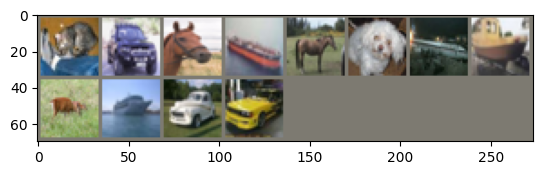

In [18]:
from torch.utils.data import Subset
from torchvision.utils import make_grid

# 获取测试集图像
samples_test_images = Subset(test_images, range(12))
sample_images, ignored_labeles_indeces = zip(*samples_test_images)

# 展示图像
display_img(make_grid(list(sample_images)))

# 测试
for sample_image in sample_images:
    pred = net(sample_image)
    print(train_images.classes[pred.argmax()])

In [19]:
test_loader = DataLoader(dataset=test_images, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

preds = []
for X, _ in test_loader:
    y_hat = net(X)
    preds.extend(y_hat.argmax(dim=1))
# 从测试集图像路径中提取图像的 id（去掉路径前缀和文件扩展名）
# 从测试集图像路径中提取图像的 id（去掉路径前缀和文件扩展名）
ids = [os.path.splitext(os.path.basename(path))[0] for path, _ in test_loader.dataset.imgs]

# 创建一个DataFrame，其中包含图像的id和对应的预测标签
df = pd.DataFrame({'id': ids, 'label': map(lambda i: train_images.classes[i], preds)})

# 将DataFrame保存到CSV文件中
df.to_csv('./imageclassification/working/submission.csv', index=False)

In [20]:
import pandas as pd

# 读取正确标签的CSV文件，假设文件名为 'true_labels.csv'
true_labels = pd.read_csv('./imageclassification/temp/testLables.csv', index_col='id')

# 读取预测标签的CSV文件，假设文件名为 'predicted_labels.csv'
predicted_labels = pd.read_csv('./imageclassification/working/submission.csv', index_col='id')

# 将两个DataFrame按照id进行合并
merged_data = pd.merge(true_labels, predicted_labels, left_index=True, right_index=True, suffixes=('_true', '_predicted'))

# 统计正确的数量
correct_count = (merged_data['label_true'] == merged_data['label_predicted']).sum()

# 打印结果
print(f"Number of correct predictions: {correct_count}")
accury = correct_count/10000
print(accury)

Number of correct predictions: 5985
0.5985
